In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.ml.feature import StringIndexer,OneHotEncoder
from pyspark.sql import SQLContext, SparkSession, Row
from pyspark.mllib.stat import Statistics
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, MinMaxScaler, StandardScaler
from pyspark.sql.functions import col

from pyspark.mllib.regression import LabeledPoint
from pyspark.ml.linalg import Vectors

spark = SparkSession.Builder().appName('DDAM_Project_south').getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/12/16 18:03:15 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/12/16 18:03:40 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [2]:
df = spark.read.options(inferSchema = True, delimiter = ',', header = True).csv('../../Datasets/South_Incidents_Cleaned.csv')

Preparing data

In [3]:
to_drop=['Start_Time','City','County','State','Wind_Direction','day_of_the_week','season']
df_class=df.drop(*to_drop)
#df_class.show()

In [4]:
colonne_booleane = ['Amenity', 'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal']

# Converti le colonne booleane in numeriche
for col_name in colonne_booleane:
    df_class = df_class.withColumn(col_name, col(col_name).cast("int"))

#df_class.show()


In [5]:
from pyspark.sql.functions import when, count, isnull
df_class = df_class.withColumn("Astronomical_Twilight", when(df_class["Astronomical_Twilight"] == 'Day', 0).otherwise(1))
df_class = df_class.withColumn("Working_Weekend", when(df_class["Working_Weekend"] == 'WorkingDay', 0).otherwise(1))

In [6]:
indexer = StringIndexer(inputCol="Weather_Condition", outputCol="Weather_Condition_Indexed")
df_class = indexer.fit(df_class).transform(df_class)

In [7]:
from pyspark.ml.feature import OneHotEncoder
onehotencoder_vector = OneHotEncoder(inputCol="Weather_Condition_Indexed", outputCol="Weather_Condition_1hot")
df_class = onehotencoder_vector.fit(df_class).transform(df_class)

In [11]:
df_class.printSchema()

root
 |-- Severity: integer (nullable = true)
 |-- Start_Lat: double (nullable = true)
 |-- Start_Lng: double (nullable = true)
 |-- Distance_mi: double (nullable = true)
 |-- Temperature_F: double (nullable = true)
 |-- Humidity_perc: double (nullable = true)
 |-- Visibility_mi: double (nullable = true)
 |-- Wind_Speed_mph: double (nullable = true)
 |-- Precipitation_in: double (nullable = true)
 |-- Amenity: integer (nullable = true)
 |-- Bump: integer (nullable = true)
 |-- Crossing: integer (nullable = true)
 |-- Give_Way: integer (nullable = true)
 |-- Junction: integer (nullable = true)
 |-- No_Exit: integer (nullable = true)
 |-- Railway: integer (nullable = true)
 |-- Roundabout: integer (nullable = true)
 |-- Station: integer (nullable = true)
 |-- Stop: integer (nullable = true)
 |-- Traffic_Calming: integer (nullable = true)
 |-- Traffic_Signal: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- hour: integer (nullable = true)
 |-- Astronomical_Twilight: in

In [8]:
df_class=df_class.drop('Weather_Condition')
#df_class.show()


In [9]:
df_class=df_class.drop('Weather_Condition_Indexed')

In [10]:
num_col = [item[0] for item in df_class.dtypes if not item[1].startswith('string')]
num_col.remove("Working_Weekend")
print(num_col)

['Severity', 'Start_Lat', 'Start_Lng', 'Distance_mi', 'Temperature_F', 'Humidity_perc', 'Visibility_mi', 'Wind_Speed_mph', 'Precipitation_in', 'Amenity', 'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal', 'month', 'hour', 'Astronomical_Twilight', 'Weather_Condition_1hot']


In [11]:
assembler = VectorAssembler(inputCols=num_col, outputCol="features")

output_dataset = assembler.transform(df_class)

classificationData = output_dataset.select("features", "Working_Weekend")

#classificationData.show(truncate=False)

In [12]:
(trainingData, testData) = classificationData.randomSplit([0.7, 0.3],seed=0)

In [13]:
from pyspark.sql import functions as F
g=trainingData.groupBy('Working_Weekend').agg(F.count('Working_Weekend').alias('Count'))
g=g.sort('Working_Weekend')
g.show()

23/12/16 18:28:06 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+---------------+-----+
|Working_Weekend|Count|
+---------------+-----+
|              0|92154|
|              1|21191|
+---------------+-----+



In [14]:
g_p=g.toPandas()

In [38]:
g_p

,Working_Weekend,Count
0,0,99125
1,1,22699


In [15]:
n_0=g_p.iloc[0,1]
n_1=g_p.iloc[1,1]

In [19]:
trainingData.show()

+--------------------+--------+
|            features|Severity|
+--------------------+--------+
|(28,[0,1,2,3,4,5,...|       1|
|(28,[0,1,2,3,4,5,...|       1|
|(28,[0,1,2,3,4,5,...|       1|
|(28,[0,1,2,3,4,5,...|       1|
|(28,[0,1,2,3,4,5,...|       1|
|(28,[0,1,2,3,4,5,...|       1|
|(28,[0,1,2,3,4,5,...|       1|
|(28,[0,1,2,3,4,5,...|       1|
|(28,[0,1,2,3,4,5,...|       1|
|(28,[0,1,2,3,4,5,...|       1|
|(28,[0,1,2,3,4,5,...|       1|
|(28,[0,1,2,3,4,5,...|       3|
|(28,[0,1,2,3,4,5,...|       1|
|(28,[0,1,2,3,4,5,...|       1|
|(28,[0,1,2,3,4,5,...|       1|
|(28,[0,1,2,3,4,5,...|       1|
|(28,[0,1,2,3,4,5,...|       1|
|(28,[0,1,2,3,4,5,...|       1|
|(28,[0,1,2,3,4,5,...|       1|
|(28,[0,1,2,3,4,5,...|       1|
+--------------------+--------+
only showing top 20 rows



In [18]:
testData.show()

+--------------------+--------+
|            features|Severity|
+--------------------+--------+
|(28,[0,1,2,3,4,5,...|       2|
|(28,[0,1,2,3,4,5,...|       2|
|(28,[0,1,2,3,4,5,...|       2|
|(28,[0,1,2,3,4,5,...|       2|
|(28,[0,1,2,3,4,5,...|       2|
|(28,[0,1,2,3,4,5,...|       2|
|(28,[0,1,2,3,4,5,...|       2|
|(28,[0,1,2,3,4,5,...|       2|
|(28,[0,1,2,3,4,5,...|       2|
|(28,[0,1,2,3,4,5,...|       2|
|(28,[0,1,2,3,4,5,...|       2|
|(28,[0,1,2,3,4,5,...|       2|
|(28,[0,1,2,3,4,5,...|       2|
|(28,[0,1,2,3,4,5,...|       2|
|(28,[0,1,2,3,4,5,...|       2|
|(28,[0,1,2,3,4,5,...|       2|
|(28,[0,1,2,3,4,5,...|       2|
|(28,[0,1,2,3,4,5,...|       2|
|(28,[0,1,2,3,4,5,...|       2|
|(28,[0,1,2,3,4,5,...|       2|
+--------------------+--------+
only showing top 20 rows



### Decision Tree con iperparametri di default

In [16]:
from pyspark.ml.classification import DecisionTreeClassifier, RandomForestClassifier

In [17]:
from pyspark.ml.classification import DecisionTreeClassifier, RandomForestClassifier

dt = DecisionTreeClassifier(labelCol="Working_Weekend", featuresCol="features")

dt = dt.fit(trainingData)

In [18]:
feat_imp=dt.featureImportances
from pyspark.ml.linalg import SparseVector
non_zero_elements = [(index, value) for index, value in zip(feat_imp.indices, feat_imp.values) if value != 0]
sorted_non_zero_elements = sorted(non_zero_elements, key=lambda x: x[1], reverse=True)
print('Le features più importanti per la predizione sono :')
for el in sorted_non_zero_elements:
    if el[0]>=24:
        print(num_col[len(num_col)-1], 'con un\'importanza dello', el[1])
    else:
        print(num_col[el[0]], 'con un\'importanza dello', el[1])

Le features più importanti per la predizione sono :
Astronomical_Twilight con un'importanza dello 0.6516322089424963
Distance_mi con un'importanza dello 0.16180944969304478
hour con un'importanza dello 0.14729992162759906
month con un'importanza dello 0.023453752046478777
Wind_Speed_mph con un'importanza dello 0.014413472179057226
Start_Lat con un'importanza dello 0.000705199314751285
Severity con un'importanza dello 0.0006859961965725239


In [44]:
# Make predictions.
predictions = dt.transform(testData)

#predictions.show(20)

+--------------------+---------------+-----------------+--------------------+----------+
|            features|Working_Weekend|    rawPrediction|         probability|prediction|
+--------------------+---------------+-----------------+--------------------+----------+
|(28,[0,1,2,3,4,5,...|              0|[58715.0,12616.0]|[0.82313440159257...|       0.0|
|(28,[0,1,2,3,4,5,...|              1|  [8349.0,3805.0]|[0.68693434260325...|       0.0|
|(28,[0,1,2,3,4,5,...|              0|[58715.0,12616.0]|[0.82313440159257...|       0.0|
|(28,[0,1,2,3,4,5,...|              0|  [8349.0,3805.0]|[0.68693434260325...|       0.0|
|(28,[0,1,2,3,4,5,...|              0|  [8349.0,3805.0]|[0.68693434260325...|       0.0|
|(28,[0,1,2,3,4,5,...|              0|[58715.0,12616.0]|[0.82313440159257...|       0.0|
|(28,[0,1,2,3,4,5,...|              0|[58715.0,12616.0]|[0.82313440159257...|       0.0|
|(28,[0,1,2,3,4,5,...|              0|[58715.0,12616.0]|[0.82313440159257...|       0.0|
|(28,[0,1,2,3,4,5,...

In [18]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [45]:
# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(labelCol="Working_Weekend"
                                              , predictionCol="prediction"
                                              , metricName="accuracy")

accuracy = evaluator.evaluate(predictions)
print(accuracy)
print("Test Error = %g" % (1.0 - accuracy))

0.8132653455402326
Test Error = 0.186735


In [47]:
from pyspark.mllib.evaluation import MulticlassMetrics
# Calcolare precision, recall e F1-score
predictionAndLabels = predictions.select("prediction", "Working_Weekend").rdd.map(lambda x: (float(x[0]), float(x[1])))
metrics = MulticlassMetrics(predictionAndLabels)

list_avg=[]
for i in range(2):
    precision = metrics.precision(label=float(i))  
    recall = metrics.recall(label=float(i))
    f1Score= metrics.fMeasure(label=float(i)) # need .0
    print("Precision for class ",i,": {:.2%}".format(precision))
    print("Recall for class ",i,": {:.2%}".format(recall))
    print("avg_F1-Score for class ",i,": {:.2%}".format(f1Score))
    list_avg.append(f1Score)
    print('----------------------------')
sum_=0
print(list_avg)
for elem in list_avg:
    sum_+=elem

avg_f1=sum_/2
print('----------------------')

print("avg_F1-Score: {:.2%}".format(avg_f1))

/opt/conda/lib/python3.10/site-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Precision for class  0 : 81.41%
Recall for class  0 : 99.80%
avg_F1-Score for class  0 : 89.67%
----------------------------
Precision for class  1 : 62.67%
Recall for class  1 : 1.45%
avg_F1-Score for class  1 : 2.83%
----------------------------
[0.8967071945981752, 0.028341708542713565]
----------------------
avg_F1-Score: 46.25%


<Axes: >

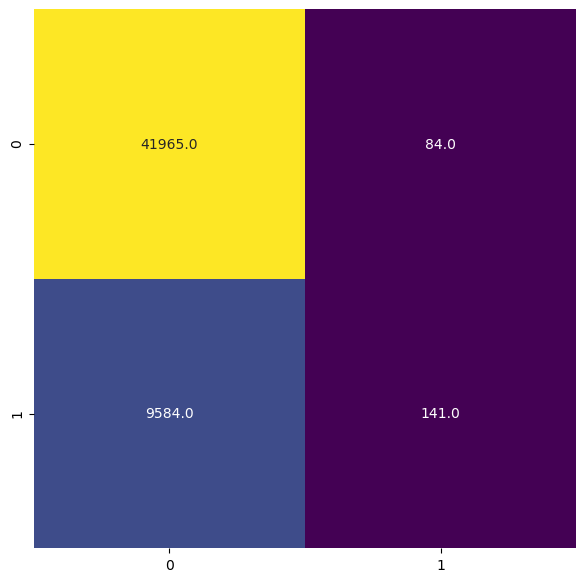

In [48]:
import seaborn as sns
import matplotlib.pyplot as plt

labels = ["0", "1"]
_ = plt.figure(figsize=(7, 7))
sns.heatmap(metrics.confusionMatrix().toArray(),
            cmap='viridis',
            annot=True,fmt='0',
            cbar=False, 
            xticklabels=labels, 
            yticklabels=labels)

### Random Forest con iperparametri di default

In [19]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import IndexToString, StringIndexer, VectorIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics

# Train a RandomForest model.
rf = RandomForestClassifier(labelCol="Working_Weekend", featuresCol="features", numTrees=10)


# Train model.  This also runs the indexers.
model = rf.fit(trainingData)

# Make predictions.
predictions = model.transform(testData)

# Select example rows to display.
#predictions.select("predictedLabel", "Severity", "features").show(5)

evaluator = MulticlassClassificationEvaluator(
    labelCol="Working_Weekend", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Test Accuracy = %g" % (accuracy))


Test Accuracy = 0.808922


In [20]:
feat_imp=model.featureImportances
from pyspark.ml.linalg import SparseVector
non_zero_elements = [(index, value) for index, value in zip(feat_imp.indices, feat_imp.values) if value != 0]
sorted_non_zero_elements = sorted(non_zero_elements, key=lambda x: x[1], reverse=True)
print('Le features più importanti per la predizione sono :')
for el in sorted_non_zero_elements:
    if el[0]>=24:
        print(num_col[len(num_col)-1], 'con un\'importanza dello', el[1])
    else:
        print(num_col[el[0]], 'con un\'importanza dello', el[1])

Le features più importanti per la predizione sono :
Astronomical_Twilight con un'importanza dello 0.24696861750392327
hour con un'importanza dello 0.24232734012243468
Distance_mi con un'importanza dello 0.14087489066069997
Severity con un'importanza dello 0.13704957310869798
Temperature_F con un'importanza dello 0.043357837408349004
month con un'importanza dello 0.041348681221712376
Visibility_mi con un'importanza dello 0.04134299603194583
Humidity_perc con un'importanza dello 0.027294771225511622
Wind_Speed_mph con un'importanza dello 0.02433888251416505
Start_Lat con un'importanza dello 0.023674940364242475
Weather_Condition_1hot con un'importanza dello 0.010905742430964163
Start_Lng con un'importanza dello 0.006455316272201579
Precipitation_in con un'importanza dello 0.003974868890618247
Railway con un'importanza dello 0.0034151520475359204
Crossing con un'importanza dello 0.0027787799140622876
Weather_Condition_1hot con un'importanza dello 0.002514243529732755
Weather_Condition_1ho

In [77]:
from pyspark.mllib.evaluation import MulticlassMetrics
# Calcolare precision, recall e F1-score
predictionAndLabels = predictions.select("prediction", "Working_Weekend").rdd.map(lambda x: (float(x[0]), float(x[1])))
metrics = MulticlassMetrics(predictionAndLabels)

list_avg=[]
for i in range(2):
    precision = metrics.precision(label=float(i))  
    recall = metrics.recall(label=float(i))
    f1Score= metrics.fMeasure(label=float(i)) # need .0
    print("Precision for class ",i,": {:.2%}".format(precision))
    print("Recall for class ",i,": {:.2%}".format(recall))
    print("avg_F1-Score for class ",i,": {:.2%}".format(f1Score))
    list_avg.append(f1Score)
    print('----------------------------')
sum_=0
print(list_avg)
for elem in list_avg:
    sum_+=elem

avg_f1=sum_/2
print('----------------------')

print("avg_F1-Score: {:.2%}".format(avg_f1))

/opt/conda/lib/python3.10/site-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Precision for class  0 : 81.22%
Recall for class  0 : 100.00%
avg_F1-Score for class  0 : 89.64%
----------------------------
Precision for class  1 : 100.00%
Recall for class  1 : 0.02%
avg_F1-Score for class  1 : 0.04%
----------------------------
[0.8963664851152727, 0.0004112264829855043]
----------------------
avg_F1-Score: 44.84%


<Axes: >

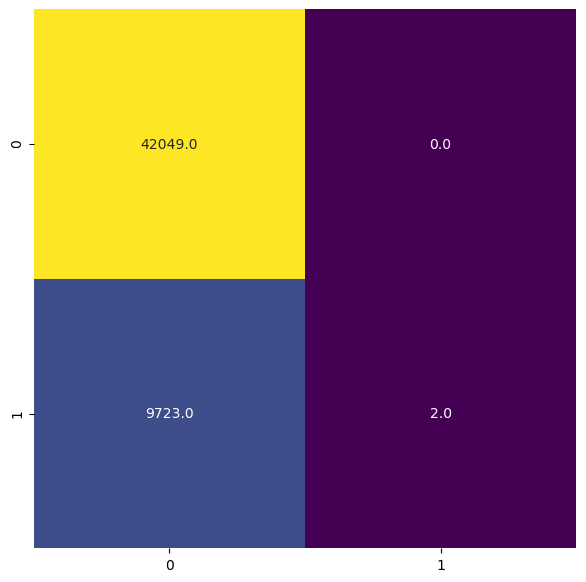

----------------------------------------
Exception occurred during processing of request from ('127.0.0.1', 47712)
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/socketserver.py", line 316, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/opt/conda/lib/python3.10/socketserver.py", line 347, in process_request
    self.finish_request(request, client_address)
  File "/opt/conda/lib/python3.10/socketserver.py", line 360, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/opt/conda/lib/python3.10/socketserver.py", line 747, in __init__
    self.handle()
  File "/opt/conda/lib/python3.10/site-packages/pyspark/accumulators.py", line 295, in handle
    poll(accum_updates)
  File "/opt/conda/lib/python3.10/site-packages/pyspark/accumulators.py", line 267, in poll
    if self.rfile in r and func():
  File "/opt/conda/lib/python3.10/site-packages/pyspark/accumulators.py", line 271, in accum_updates
   

In [78]:
import seaborn as sns
import matplotlib.pyplot as plt

labels = ["0", "1"]
_ = plt.figure(figsize=(7, 7))
sns.heatmap(metrics.confusionMatrix().toArray(),
            cmap='viridis',
            annot=True,fmt='0',
            cbar=False, 
            xticklabels=labels, 
            yticklabels=labels)

### Hyperparameter Tuning Decision Tree

In [21]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
import seaborn as sns
import matplotlib.pyplot as plt

In [22]:
n=trainingData.count()

In [23]:
max_depth=[5,15,25]
max_bins=[32,64]
min_inst=[round(0.005*n),round(0.02*n)]
impurity=['entropy', 'gini']
# Creiamo la colonna 'weights' basata sulla frequenza delle classi
trainingData_w = trainingData.withColumn("weights", when(trainingData["Working_Weekend"] == 0 , 1)#Calcolo del peso per la classe 0
    .when(trainingData["Working_Weekend"] == 1, n_0/n_1)  # Calcolo del peso per la classe 1

)


0.8146560049445668
Test Error = 0.185344


/opt/conda/lib/python3.10/site-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Precision for class  0 : 81.94%
Recall for class  0 : 99.00%
avg_F1-Score for class  0 : 89.67%
----------------------------
Precision for class  1 : 56.67%
Recall for class  1 : 5.63%
avg_F1-Score for class  1 : 10.25%
----------------------------
[0.8966571896269493, 0.1025065469509914]
----------------------
avg_F1-Score: 49.96%


<Axes: >

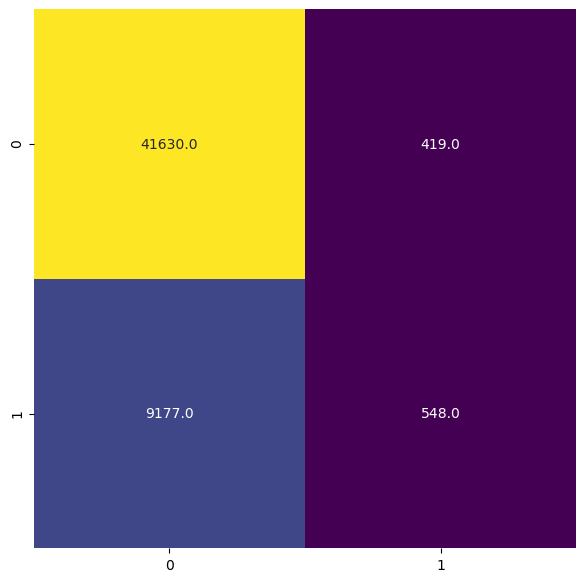

In [24]:
dt = DecisionTreeClassifier(labelCol="Working_Weekend", featuresCol="features", maxDepth=10, maxBins=64, 
                            minInstancesPerNode=round(0.005*n), impurity='entropy')
dt = dt.fit(trainingData)
predictions = dt.transform(testData)
# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(labelCol="Working_Weekend"
                                              , predictionCol="prediction"
                                              , metricName="accuracy")

accuracy = evaluator.evaluate(predictions)
print(accuracy)
print("Test Error = %g" % (1.0 - accuracy))

# Calcolare precision, recall e F1-score
predictionAndLabels = predictions.select("prediction", "Working_Weekend").rdd.map(lambda x: (float(x[0]), float(x[1])))
metrics = MulticlassMetrics(predictionAndLabels)

list_avg=[]
for i in range(2):
    precision = metrics.precision(label=float(i))  
    recall = metrics.recall(label=float(i))
    f1Score= metrics.fMeasure(label=float(i)) # need .0
    print("Precision for class ",i,": {:.2%}".format(precision))
    print("Recall for class ",i,": {:.2%}".format(recall))
    print("avg_F1-Score for class ",i,": {:.2%}".format(f1Score))
    list_avg.append(f1Score)
    print('----------------------------')
sum_=0
print(list_avg)
for elem in list_avg:
    sum_+=elem

avg_f1=sum_/2
print('----------------------')

print("avg_F1-Score: {:.2%}".format(avg_f1))

labels = ["0", "1"]
_ = plt.figure(figsize=(7, 7))
sns.heatmap(metrics.confusionMatrix().toArray(),
            cmap='viridis',
            annot=True,fmt='0',
            cbar=False, 
            xticklabels=labels, 
            yticklabels=labels)

In [26]:
feat_imp=dt.featureImportances
from pyspark.ml.linalg import SparseVector
non_zero_elements = [(index, value) for index, value in zip(feat_imp.indices, feat_imp.values) if value != 0]
sorted_non_zero_elements = sorted(non_zero_elements, key=lambda x: x[1], reverse=True)
print('Le features più importanti per la predizione sono :')
for el in sorted_non_zero_elements:
    if el[0]>=24:
        print(num_col[len(num_col)-1], 'con un\'importanza dello', el[1])
    else:
        print(num_col[el[0]], 'con un\'importanza dello', el[1])

Le features più importanti per la predizione sono :
Astronomical_Twilight con un'importanza dello 0.39674769296160967
hour con un'importanza dello 0.32836379986942116
Distance_mi con un'importanza dello 0.10371155524226432
Humidity_perc con un'importanza dello 0.05484820355043007
Temperature_F con un'importanza dello 0.05129234236474299
Severity con un'importanza dello 0.04315345507201346
Start_Lng con un'importanza dello 0.010359151214266319
Start_Lat con un'importanza dello 0.007796942498625501
month con un'importanza dello 0.003726857226626541


0.8121644068451346
Test Error = 0.187836


/opt/conda/lib/python3.10/site-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Precision for class  0 : 81.22%
Recall for class  0 : 100.00%
avg_F1-Score for class  0 : 89.63%
----------------------------
Precision for class  1 : 0.00%
Recall for class  1 : 0.00%
avg_F1-Score for class  1 : 0.00%
----------------------------
[0.8963473775087132, 0.0]
----------------------
avg_F1-Score: 44.82%


<Axes: >

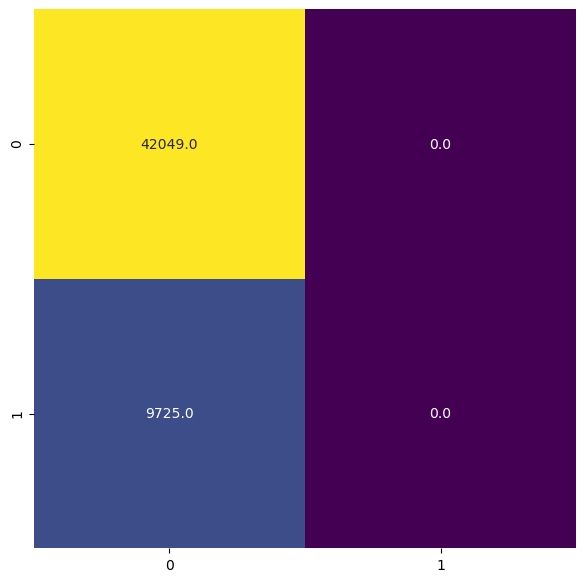

In [25]:
dt = DecisionTreeClassifier(labelCol="Working_Weekend", featuresCol="features", maxDepth=15, maxBins=32, 
                            minInstancesPerNode=round(0.02*n))
dt = dt.fit(trainingData)
predictions = dt.transform(testData)
# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(labelCol="Working_Weekend"
                                              , predictionCol="prediction"
                                              , metricName="accuracy")

accuracy = evaluator.evaluate(predictions)
print(accuracy)
print("Test Error = %g" % (1.0 - accuracy))

# Calcolare precision, recall e F1-score
predictionAndLabels = predictions.select("prediction", "Working_Weekend").rdd.map(lambda x: (float(x[0]), float(x[1])))
metrics = MulticlassMetrics(predictionAndLabels)

list_avg=[]
for i in range(2):
    precision = metrics.precision(label=float(i))  
    recall = metrics.recall(label=float(i))
    f1Score= metrics.fMeasure(label=float(i)) # need .0
    print("Precision for class ",i,": {:.2%}".format(precision))
    print("Recall for class ",i,": {:.2%}".format(recall))
    print("avg_F1-Score for class ",i,": {:.2%}".format(f1Score))
    list_avg.append(f1Score)
    print('----------------------------')
sum_=0
print(list_avg)
for elem in list_avg:
    sum_+=elem

avg_f1=sum_/2
print('----------------------')

print("avg_F1-Score: {:.2%}".format(avg_f1))

labels = ["0", "1"]
_ = plt.figure(figsize=(7, 7))
sns.heatmap(metrics.confusionMatrix().toArray(),
            cmap='viridis',
            annot=True,fmt='0',
            cbar=False, 
            xticklabels=labels, 
            yticklabels=labels)

In [36]:
feat_imp=dt.featureImportances
from pyspark.ml.linalg import SparseVector
non_zero_elements = [(index, value) for index, value in zip(feat_imp.indices, feat_imp.values) if value != 0]
sorted_non_zero_elements = sorted(non_zero_elements, key=lambda x: x[1], reverse=True)
print('Le features più importanti per la predizione sono :')
for el in sorted_non_zero_elements:
    print(num_col[el[0]], 'con un\'importanza dello', el[1])

Le features più importanti per la predizione sono :


0.8146560049445668
Test Error = 0.185344


/opt/conda/lib/python3.10/site-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Precision for class  0 : 81.94%
Recall for class  0 : 99.00%
avg_F1-Score for class  0 : 89.67%
----------------------------
Precision for class  1 : 56.67%
Recall for class  1 : 5.63%
avg_F1-Score for class  1 : 10.25%
----------------------------
[0.8966571896269493, 0.1025065469509914]
----------------------
avg_F1-Score: 49.96%


<Axes: >

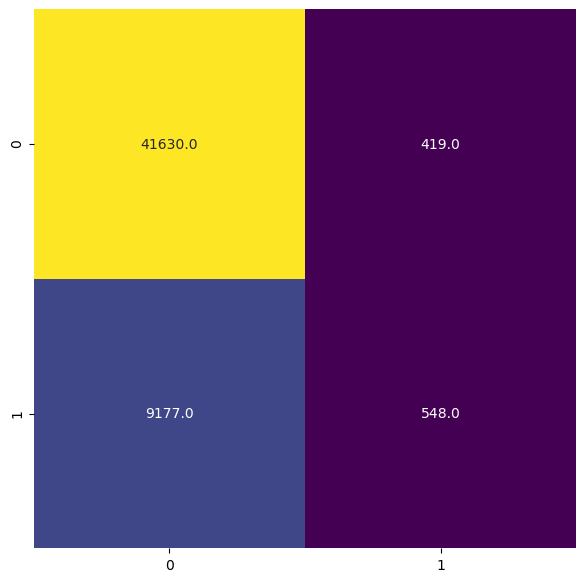

In [26]:
dt = DecisionTreeClassifier(labelCol="Working_Weekend", featuresCol="features", maxDepth=25, maxBins=64,
                            minInstancesPerNode=round(0.005*n), impurity='entropy' )
dt = dt.fit(trainingData)
predictions = dt.transform(testData)
# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(labelCol="Working_Weekend"
                                              , predictionCol="prediction"
                                              , metricName="accuracy")

accuracy = evaluator.evaluate(predictions)
print(accuracy)
print("Test Error = %g" % (1.0 - accuracy))

# Calcolare precision, recall e F1-score
predictionAndLabels = predictions.select("prediction", "Working_Weekend").rdd.map(lambda x: (float(x[0]), float(x[1])))
metrics = MulticlassMetrics(predictionAndLabels)

list_avg=[]
for i in range(2):
    precision = metrics.precision(label=float(i))  
    recall = metrics.recall(label=float(i))
    f1Score= metrics.fMeasure(label=float(i)) # need .0
    print("Precision for class ",i,": {:.2%}".format(precision))
    print("Recall for class ",i,": {:.2%}".format(recall))
    print("avg_F1-Score for class ",i,": {:.2%}".format(f1Score))
    list_avg.append(f1Score)
    print('----------------------------')
sum_=0
print(list_avg)
for elem in list_avg:
    sum_+=elem

avg_f1=sum_/2
print('----------------------')

print("avg_F1-Score: {:.2%}".format(avg_f1))

labels = ["0", "1"]
_ = plt.figure(figsize=(7, 7))
sns.heatmap(metrics.confusionMatrix().toArray(),
            cmap='viridis',
            annot=True,fmt='0',
            cbar=False, 
            xticklabels=labels, 
            yticklabels=labels)

In [34]:
feat_imp=dt.featureImportances
from pyspark.ml.linalg import SparseVector
non_zero_elements = [(index, value) for index, value in zip(feat_imp.indices, feat_imp.values) if value != 0]
sorted_non_zero_elements = sorted(non_zero_elements, key=lambda x: x[1], reverse=True)
print('Le features più importanti per la predizione sono :')
for el in sorted_non_zero_elements:
    print(num_col[el[0]], 'con un\'importanza dello', el[1])

Le features più importanti per la predizione sono :
Astronomical_Twilight con un'importanza dello 0.39674769296160967
hour con un'importanza dello 0.32836379986942116
Distance_mi con un'importanza dello 0.10371155524226432
Humidity_perc con un'importanza dello 0.05484820355043007
Temperature_F con un'importanza dello 0.05129234236474299
Severity con un'importanza dello 0.04315345507201346
Start_Lng con un'importanza dello 0.010359151214266319
Start_Lat con un'importanza dello 0.007796942498625501
month con un'importanza dello 0.003726857226626541


0.6118901379070576
Test Error = 0.38811


/opt/conda/lib/python3.10/site-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Precision for class  0 : 88.58%
Recall for class  0 : 59.94%
avg_F1-Score for class  0 : 71.50%
----------------------------
Precision for class  1 : 27.77%
Recall for class  1 : 66.60%
avg_F1-Score for class  1 : 39.20%
----------------------------
[0.7149787234042553, 0.39197530864197533]
----------------------
avg_F1-Score: 55.35%


<Axes: >

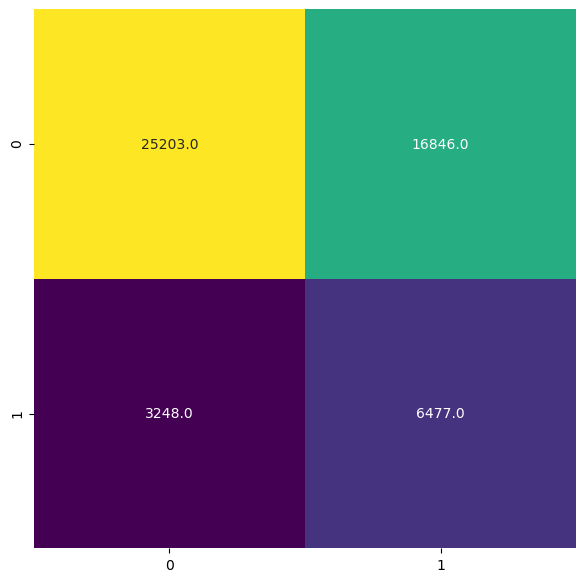

In [28]:
trainingData_w = trainingData.withColumn("weights", when(trainingData["Working_Weekend"] == 0 , 1)#Calcolo del peso per la classe 0
    .when(trainingData["Working_Weekend"] == 1, n_0/n_1)  # Calcolo del peso per la classe 1

)

dt = DecisionTreeClassifier(labelCol="Working_Weekend", featuresCol="features", maxDepth=10, maxBins=32, 
                            minInstancesPerNode=round(0.02*n), weightCol='weights')
dt = dt.fit(trainingData_w)
predictions = dt.transform(testData)
# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(labelCol="Working_Weekend"
                                              , predictionCol="prediction"
                                              , metricName="accuracy")

accuracy = evaluator.evaluate(predictions)
print(accuracy)
print("Test Error = %g" % (1.0 - accuracy))

# Calcolare precision, recall e F1-score
predictionAndLabels = predictions.select("prediction", "Working_Weekend").rdd.map(lambda x: (float(x[0]), float(x[1])))
metrics = MulticlassMetrics(predictionAndLabels)

list_avg=[]
for i in range(2):
    precision = metrics.precision(label=float(i))  
    recall = metrics.recall(label=float(i))
    f1Score= metrics.fMeasure(label=float(i)) # need .0
    print("Precision for class ",i,": {:.2%}".format(precision))
    print("Recall for class ",i,": {:.2%}".format(recall))
    print("avg_F1-Score for class ",i,": {:.2%}".format(f1Score))
    list_avg.append(f1Score)
    print('----------------------------')
sum_=0
print(list_avg)
for elem in list_avg:
    sum_+=elem

avg_f1=sum_/2
print('----------------------')

print("avg_F1-Score: {:.2%}".format(avg_f1))

labels = ["0", "1"]
_ = plt.figure(figsize=(7, 7))
sns.heatmap(metrics.confusionMatrix().toArray(),
            cmap='viridis',
            annot=True,fmt='0',
            cbar=False, 
            xticklabels=labels, 
            yticklabels=labels)

In [38]:
feat_imp=dt.featureImportances
from pyspark.ml.linalg import SparseVector
non_zero_elements = [(index, value) for index, value in zip(feat_imp.indices, feat_imp.values) if value != 0]
sorted_non_zero_elements = sorted(non_zero_elements, key=lambda x: x[1], reverse=True)
print('Le features più importanti per la predizione sono :')
for el in sorted_non_zero_elements:
    print(num_col[el[0]], 'con un\'importanza dello', el[1])

Le features più importanti per la predizione sono :
hour con un'importanza dello 0.4180572181839158
Astronomical_Twilight con un'importanza dello 0.3658356693882028
Distance_mi con un'importanza dello 0.06957409259532209
Severity con un'importanza dello 0.03923707455152482
Humidity_perc con un'importanza dello 0.037652383430681786
Temperature_F con un'importanza dello 0.0259586025040222
Wind_Speed_mph con un'importanza dello 0.012531048376619055
Start_Lat con un'importanza dello 0.011451612559550267
Start_Lng con un'importanza dello 0.010977080148193591
month con un'importanza dello 0.008725218261967666


/opt/conda/lib/python3.10/site-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


0.8134584926797234
Test Error = 0.186542


Precision for class  0 : 82.44%
Recall for class  0 : 97.89%
avg_F1-Score for class  0 : 89.50%
----------------------------
Precision for class  1 : 51.82%
Recall for class  1 : 9.83%
avg_F1-Score for class  1 : 16.53%
----------------------------
[0.8949966296288242, 0.16525496974935178]
----------------------
avg_F1-Score: 53.01%


<Axes: >

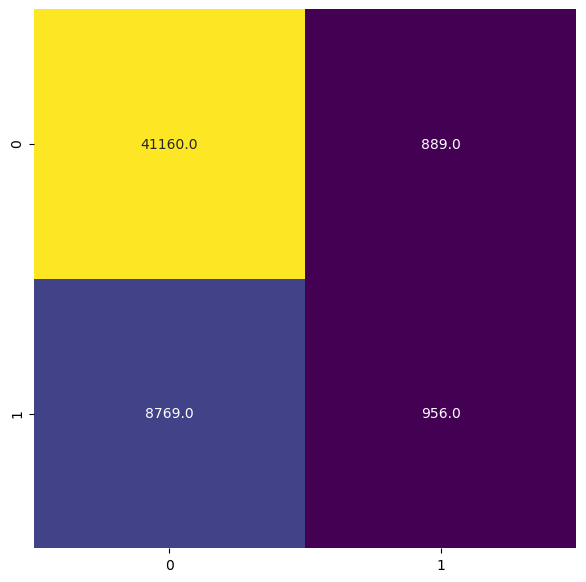

In [32]:
trainingData_w = trainingData.withColumn("weights", when(trainingData["Working_Weekend"] == 0 , 1)#Calcolo del peso per la classe 0
    .when(trainingData["Working_Weekend"] == 1, 1.2)  # Calcolo del peso per la classe 1

)

dt = DecisionTreeClassifier(labelCol="Working_Weekend", featuresCol="features", maxDepth=25, maxBins=64,
                            minInstancesPerNode=round(0.005*n), impurity='entropy', weightCol='weights' )
dt = dt.fit(trainingData_w)
predictions = dt.transform(testData)
# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(labelCol="Working_Weekend"
                                              , predictionCol="prediction"
                                              , metricName="accuracy")

accuracy = evaluator.evaluate(predictions)
print(accuracy)
print("Test Error = %g" % (1.0 - accuracy))

# Calcolare precision, recall e F1-score
predictionAndLabels = predictions.select("prediction", "Working_Weekend").rdd.map(lambda x: (float(x[0]), float(x[1])))
metrics = MulticlassMetrics(predictionAndLabels)

list_avg=[]
for i in range(2):
    precision = metrics.precision(label=float(i))  
    recall = metrics.recall(label=float(i))
    f1Score= metrics.fMeasure(label=float(i)) # need .0
    print("Precision for class ",i,": {:.2%}".format(precision))
    print("Recall for class ",i,": {:.2%}".format(recall))
    print("avg_F1-Score for class ",i,": {:.2%}".format(f1Score))
    list_avg.append(f1Score)
    print('----------------------------')
sum_=0
print(list_avg)
for elem in list_avg:
    sum_+=elem

avg_f1=sum_/2
print('----------------------')

print("avg_F1-Score: {:.2%}".format(avg_f1))

labels = ["0", "1"]
_ = plt.figure(figsize=(7, 7))
sns.heatmap(metrics.confusionMatrix().toArray(),
            cmap='viridis',
            annot=True,fmt='0',
            cbar=False, 
            xticklabels=labels, 
            yticklabels=labels)

In [40]:
feat_imp=dt.featureImportances
from pyspark.ml.linalg import SparseVector
non_zero_elements = [(index, value) for index, value in zip(feat_imp.indices, feat_imp.values) if value != 0]
sorted_non_zero_elements = sorted(non_zero_elements, key=lambda x: x[1], reverse=True)
print('Le features più importanti per la predizione sono :')
for el in sorted_non_zero_elements:
    print(num_col[el[0]], 'con un\'importanza dello', el[1])

Le features più importanti per la predizione sono :
Astronomical_Twilight con un'importanza dello 0.39673305939649506
hour con un'importanza dello 0.3314160939708721
Distance_mi con un'importanza dello 0.10321486736392307
Humidity_perc con un'importanza dello 0.05276530679588937
Temperature_F con un'importanza dello 0.050757792267868015
Severity con un'importanza dello 0.04416765816080697
Start_Lng con un'importanza dello 0.009971992321348211
Start_Lat con un'importanza dello 0.007501022574755842
month con un'importanza dello 0.0034722071480412027


### Hyperparameter Tuning Random Forest

Test Accuracy = 0.818055
Alberi :  5 maxDepth :  10


/opt/conda/lib/python3.10/site-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Precision for class  0 : 81.99%
Recall for class  0 : 99.43%
avg_F1-Score for class  0 : 89.88%
----------------------------
Precision for class  1 : 69.48%
Recall for class  1 : 5.59%
avg_F1-Score for class  1 : 10.35%
----------------------------
[0.8987532244196045, 0.10354015987818804]
----------------------
avg_F1-Score: 50.11%


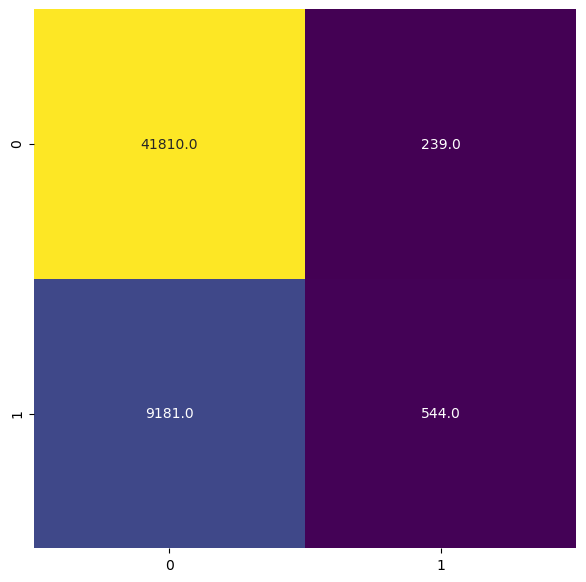

23/12/13 17:43:08 WARN DAGScheduler: Broadcasting large task binary with size 1155.1 KiB
23/12/13 17:43:11 WARN DAGScheduler: Broadcasting large task binary with size 1611.1 KiB
23/12/13 17:43:14 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
23/12/13 17:43:16 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
23/12/13 17:43:19 WARN DAGScheduler: Broadcasting large task binary with size 1767.7 KiB
/opt/conda/lib/python3.10/site-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Test Accuracy = 0.83032
Alberi :  5 maxDepth :  15


23/12/13 17:43:25 WARN DAGScheduler: Broadcasting large task binary with size 1755.4 KiB
23/12/13 17:43:26 WARN DAGScheduler: Broadcasting large task binary with size 1766.7 KiB


Precision for class  0 : 83.42%
Recall for class  0 : 98.73%
avg_F1-Score for class  0 : 90.43%
----------------------------
Precision for class  1 : 73.43%
Recall for class  1 : 15.15%
avg_F1-Score for class  1 : 25.11%
----------------------------
[0.9043205506605531, 0.25112948597732504]
----------------------
avg_F1-Score: 57.77%


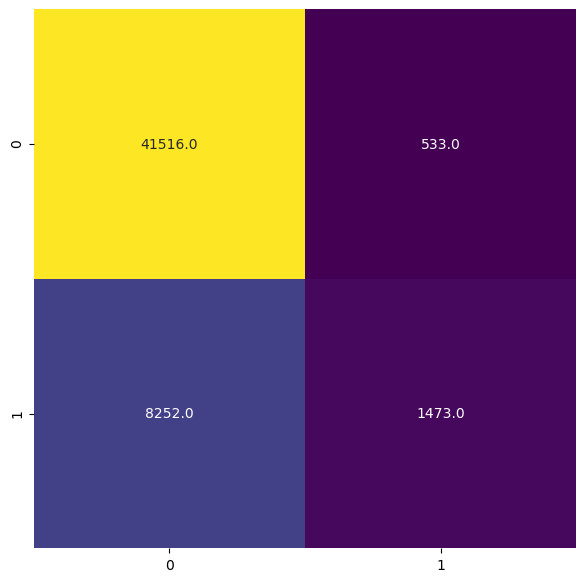

23/12/13 17:43:57 WARN DAGScheduler: Broadcasting large task binary with size 1155.1 KiB
23/12/13 17:44:00 WARN DAGScheduler: Broadcasting large task binary with size 1611.1 KiB
23/12/13 17:44:03 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
23/12/13 17:44:06 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
23/12/13 17:44:09 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB
23/12/13 17:44:13 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
23/12/13 17:44:19 WARN DAGScheduler: Broadcasting large task binary with size 5.5 MiB
23/12/13 17:44:24 WARN DAGScheduler: Broadcasting large task binary with size 6.5 MiB
23/12/13 17:44:29 WARN DAGScheduler: Broadcasting large task binary with size 7.6 MiB
23/12/13 17:44:38 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB


Test Accuracy = 0.846718
Alberi :  5 maxDepth :  20


/opt/conda/lib/python3.10/site-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(
23/12/13 17:44:50 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
23/12/13 17:44:53 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB


Precision for class  0 : 85.46%
Recall for class  0 : 97.76%
avg_F1-Score for class  0 : 91.20%
----------------------------
Precision for class  1 : 74.34%
Recall for class  1 : 28.09%
avg_F1-Score for class  1 : 40.78%
----------------------------
[0.9119669876203575, 0.4077611940298508]
----------------------
avg_F1-Score: 65.99%


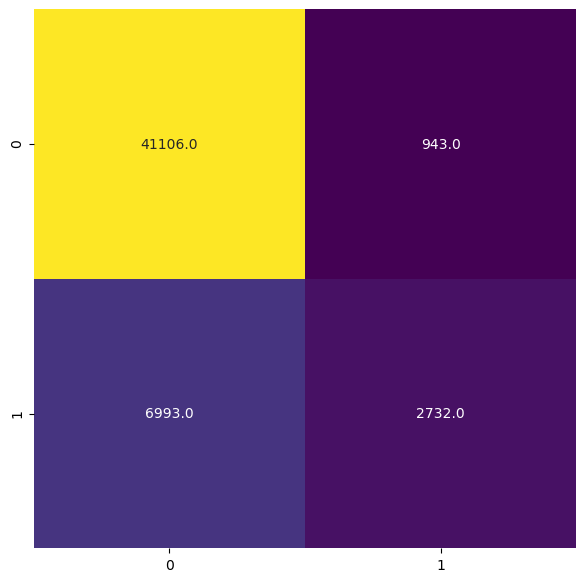

----------------------------------------
Exception occurred during processing of request from ('127.0.0.1', 33040)
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/socketserver.py", line 316, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/opt/conda/lib/python3.10/socketserver.py", line 347, in process_request
    self.finish_request(request, client_address)
  File "/opt/conda/lib/python3.10/socketserver.py", line 360, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/opt/conda/lib/python3.10/socketserver.py", line 747, in __init__
    self.handle()
  File "/opt/conda/lib/python3.10/site-packages/pyspark/accumulators.py", line 295, in handle
    poll(accum_updates)
  File "/opt/conda/lib/python3.10/site-packages/pyspark/accumulators.py", line 267, in poll
    if self.rfile in r and func():
  File "/opt/conda/lib/python3.10/site-packages/pyspark/accumulators.py", line 271, in accum_updates
   

In [26]:
for maxDepth in range(10,21,5):
    rf = RandomForestClassifier(labelCol="Working_Weekend", featuresCol="features", numTrees=5,maxDepth= maxDepth) 
    # Addestra il modello sul set di dati sottocampionato
    model = rf.fit(trainingData) 
    predictions = model.transform(testData)
    evaluator = MulticlassClassificationEvaluator(
    labelCol="Working_Weekend", predictionCol="prediction", metricName="accuracy")
    accuracy = evaluator.evaluate(predictions)
    print("Test Accuracy = %g" % accuracy) 
    print("Alberi : ",5,"maxDepth : ",maxDepth)
    from pyspark.mllib.evaluation import MulticlassMetrics
    # Calcolare precision, recall e F1-score
    predictionAndLabels = predictions.select("prediction", "Working_Weekend").rdd.map(lambda x: (float(x[0]), float(x[1])))
    metrics = MulticlassMetrics(predictionAndLabels)

    list_avg=[]
    for i in range(2):
        precision = metrics.precision(label=float(i))  
        recall = metrics.recall(label=float(i))
        f1Score= metrics.fMeasure(label=float(i)) # need .0
        print("Precision for class ",i,": {:.2%}".format(precision))
        print("Recall for class ",i,": {:.2%}".format(recall))
        print("avg_F1-Score for class ",i,": {:.2%}".format(f1Score))
        list_avg.append(f1Score)
        print('----------------------------')
    sum_=0
    print(list_avg)
    for elem in list_avg:
        sum_+=elem

    avg_f1=sum_/2
    print('----------------------')

    print("avg_F1-Score: {:.2%}".format(avg_f1))
    import seaborn as sns
    import matplotlib.pyplot as plt
    labels = ["0", "1"]
    _ = plt.figure(figsize=(7, 7))
    sns.heatmap(metrics.confusionMatrix().toArray(),
                cmap='viridis',
                annot=True,fmt='0',
                cbar=False, 
                xticklabels=labels, 
                yticklabels=labels)
    plt.show()

### Undersampling Decision Tree

In [41]:
train_und = trainingData.sampleBy('Working_Weekend', fractions={0:n_1/n_0 ,1: 1})

In [42]:
from pyspark.ml.classification import DecisionTreeClassifier

dt = DecisionTreeClassifier(labelCol="Working_Weekend", featuresCol="features")

dt = dt.fit(train_und)

In [43]:
feat_imp=dt.featureImportances
from pyspark.ml.linalg import SparseVector
non_zero_elements = [(index, value) for index, value in zip(feat_imp.indices, feat_imp.values) if value != 0]
sorted_non_zero_elements = sorted(non_zero_elements, key=lambda x: x[1], reverse=True)
print('Le features più importanti per la predizione sono :')
for el in sorted_non_zero_elements:
    print(num_col[el[0]], 'con un\'importanza dello', el[1])

Le features più importanti per la predizione sono :
hour con un'importanza dello 0.41381551402056416
Astronomical_Twilight con un'importanza dello 0.40355079304729086
Distance_mi con un'importanza dello 0.0915637409767024
Severity con un'importanza dello 0.044475370756716856
Temperature_F con un'importanza dello 0.03079040398108429
Start_Lng con un'importanza dello 0.008395077877697964
Precipitation_in con un'importanza dello 0.004600507643728077
Wind_Speed_mph con un'importanza dello 0.001460303471199964
Start_Lat con un'importanza dello 0.0013482882250155247


In [55]:
# Make predictions.
predictions = dt.transform(testData)

#predictions.show(20)

In [56]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [57]:
# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(labelCol="Working_Weekend"
                                              , predictionCol="prediction"
                                              , metricName="accuracy")

accuracy = evaluator.evaluate(predictions)
print(accuracy)
print("Test Error = %g" % (1.0 - accuracy))

0.5812956310117047
Test Error = 0.418704


In [58]:
from pyspark.mllib.evaluation import MulticlassMetrics
# Calcolare precision, recall e F1-score
predictionAndLabels = predictions.select("prediction", "Working_Weekend").rdd.map(lambda x: (float(x[0]), float(x[1])))
metrics = MulticlassMetrics(predictionAndLabels)

list_avg=[]
for i in range(2):
    precision = metrics.precision(label=float(i))  
    recall = metrics.recall(label=float(i))
    f1Score= metrics.fMeasure(label=float(i)) # need .0
    print("Precision for class ",i,": {:.2%}".format(precision))
    print("Recall for class ",i,": {:.2%}".format(recall))
    print("avg_F1-Score for class ",i,": {:.2%}".format(f1Score))
    list_avg.append(f1Score)
    print('----------------------------')
sum_=0
print(list_avg)
for elem in list_avg:
    sum_+=elem

avg_f1=sum_/2
print('----------------------')

print("avg_F1-Score: {:.2%}".format(avg_f1))

/opt/conda/lib/python3.10/site-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Precision for class  0 : 87.78%
Recall for class  0 : 56.28%
avg_F1-Score for class  0 : 68.59%
----------------------------
Precision for class  1 : 25.91%
Recall for class  1 : 66.11%
avg_F1-Score for class  1 : 37.23%
----------------------------
[0.6858807163971482, 0.3723071577484364]
----------------------
avg_F1-Score: 52.91%


<Axes: >

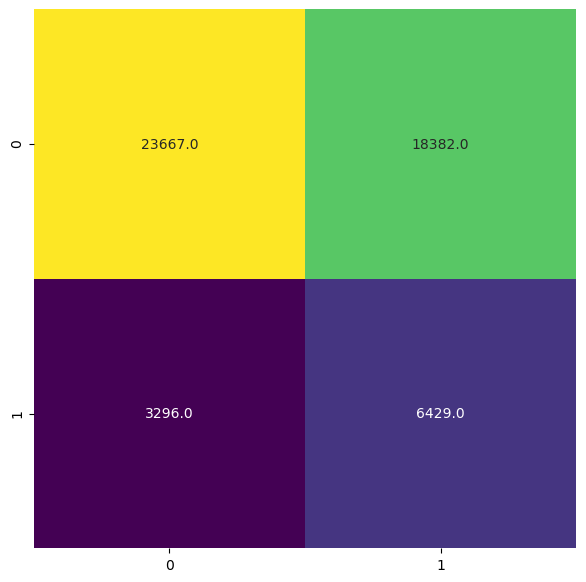

In [59]:
import seaborn as sns
import matplotlib.pyplot as plt

labels = ["0", "1"]
_ = plt.figure(figsize=(7, 7))
sns.heatmap(metrics.confusionMatrix().toArray(),
            cmap='viridis',
            annot=True,fmt='0',
            cbar=False, 
            xticklabels=labels, 
            yticklabels=labels)

### Undersampling Random Forest

23/12/13 17:55:37 WARN DAGScheduler: Broadcasting large task binary with size 1065.3 KiB
23/12/13 17:55:42 WARN DAGScheduler: Broadcasting large task binary with size 1449.6 KiB
23/12/13 17:55:48 WARN DAGScheduler: Broadcasting large task binary with size 1910.4 KiB
23/12/13 17:55:53 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


Test Accuracy = 0.665083
Alberi :  5 maxDepth :  10


/opt/conda/lib/python3.10/site-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Precision for class  0 : 89.32%
Recall for class  0 : 66.74%
avg_F1-Score for class  0 : 76.40%
----------------------------
Precision for class  1 : 31.29%
Recall for class  1 : 65.50%
avg_F1-Score for class  1 : 42.35%
----------------------------
[0.7639788751565307, 0.4235372340425532]
----------------------
avg_F1-Score: 59.38%


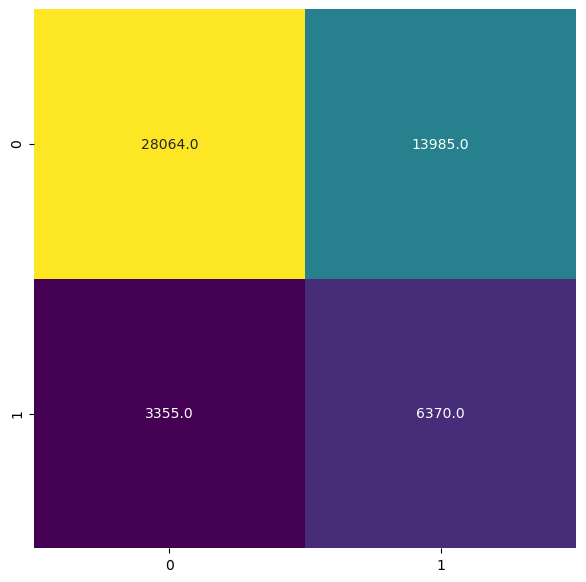

23/12/13 17:56:34 WARN DAGScheduler: Broadcasting large task binary with size 1065.3 KiB
23/12/13 17:56:35 WARN DAGScheduler: Broadcasting large task binary with size 1449.6 KiB
23/12/13 17:56:37 WARN DAGScheduler: Broadcasting large task binary with size 1910.4 KiB
23/12/13 17:56:39 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
23/12/13 17:56:41 WARN DAGScheduler: Broadcasting large task binary with size 1608.0 KiB
/opt/conda/lib/python3.10/site-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Test Accuracy = 0.692471
Alberi :  5 maxDepth :  15


23/12/13 17:56:46 WARN DAGScheduler: Broadcasting large task binary with size 1595.7 KiB
23/12/13 17:56:46 WARN DAGScheduler: Broadcasting large task binary with size 1607.0 KiB


Precision for class  0 : 91.39%
Recall for class  0 : 68.59%
avg_F1-Score for class  0 : 78.37%
----------------------------
Precision for class  1 : 34.67%
Recall for class  1 : 72.07%
avg_F1-Score for class  1 : 46.82%
----------------------------
[0.7836919900010868, 0.4682030728122913]
----------------------
avg_F1-Score: 62.59%


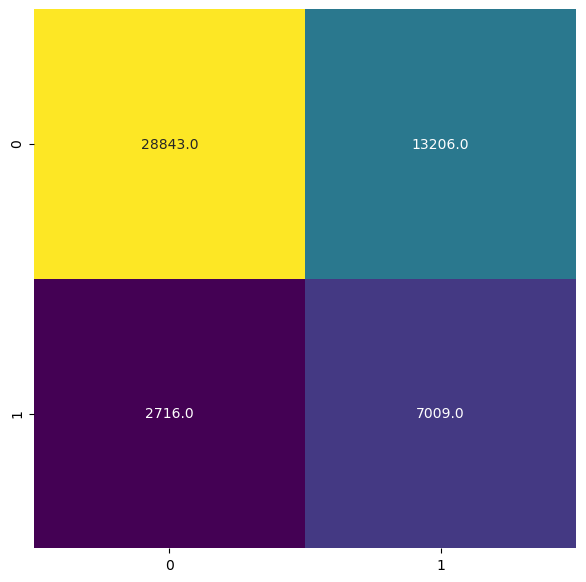

23/12/13 17:57:12 WARN DAGScheduler: Broadcasting large task binary with size 1065.3 KiB
23/12/13 17:57:13 WARN DAGScheduler: Broadcasting large task binary with size 1449.6 KiB
23/12/13 17:57:14 WARN DAGScheduler: Broadcasting large task binary with size 1910.4 KiB
23/12/13 17:57:15 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
23/12/13 17:57:17 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
23/12/13 17:57:21 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB
23/12/13 17:57:24 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB
23/12/13 17:57:26 WARN DAGScheduler: Broadcasting large task binary with size 4.9 MiB
23/12/13 17:57:28 WARN DAGScheduler: Broadcasting large task binary with size 5.6 MiB
23/12/13 17:57:33 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB


Test Accuracy = 0.715398
Alberi :  5 maxDepth :  20


/opt/conda/lib/python3.10/site-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(
23/12/13 17:57:37 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
23/12/13 17:57:38 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB


Precision for class  0 : 92.48%
Recall for class  0 : 70.71%
avg_F1-Score for class  0 : 80.14%
----------------------------
Precision for class  1 : 37.23%
Recall for class  1 : 75.13%
avg_F1-Score for class  1 : 49.79%
----------------------------
[0.8014177706499913, 0.49790438545677584]
----------------------
avg_F1-Score: 64.97%


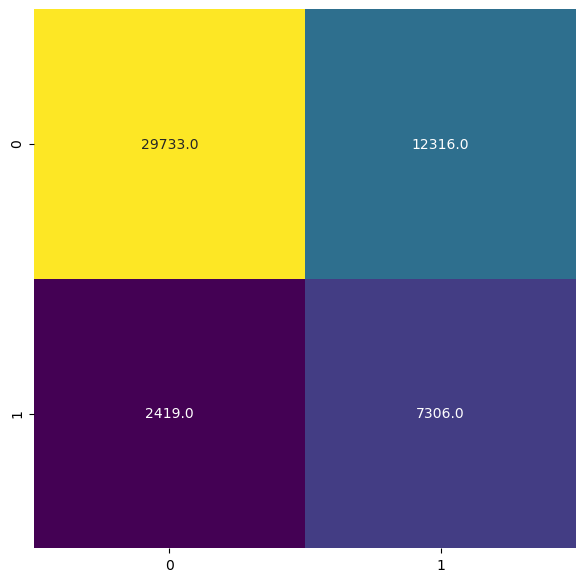

In [24]:
for maxDepth in range(10,21,5):
    rf = RandomForestClassifier(labelCol="Working_Weekend", featuresCol="features", numTrees=5,maxDepth= maxDepth) 
    # Addestra il modello sul set di dati sottocampionato
    model = rf.fit(train_und) 
    predictions = model.transform(testData)
    evaluator = MulticlassClassificationEvaluator(
    labelCol="Working_Weekend", predictionCol="prediction", metricName="accuracy")
    accuracy = evaluator.evaluate(predictions)
    print("Test Accuracy = %g" % accuracy) 
    print("Alberi : ",5,"maxDepth : ",maxDepth)
    from pyspark.mllib.evaluation import MulticlassMetrics
    # Calcolare precision, recall e F1-score
    predictionAndLabels = predictions.select("prediction", "Working_Weekend").rdd.map(lambda x: (float(x[0]), float(x[1])))
    metrics = MulticlassMetrics(predictionAndLabels)

    list_avg=[]
    for i in range(2):
        precision = metrics.precision(label=float(i))  
        recall = metrics.recall(label=float(i))
        f1Score= metrics.fMeasure(label=float(i)) # need .0
        print("Precision for class ",i,": {:.2%}".format(precision))
        print("Recall for class ",i,": {:.2%}".format(recall))
        print("avg_F1-Score for class ",i,": {:.2%}".format(f1Score))
        list_avg.append(f1Score)
        print('----------------------------')
    sum_=0
    print(list_avg)
    for elem in list_avg:
        sum_+=elem

    avg_f1=sum_/2
    print('----------------------')

    print("avg_F1-Score: {:.2%}".format(avg_f1))
    import seaborn as sns
    import matplotlib.pyplot as plt
    labels = ["0", "1"]
    _ = plt.figure(figsize=(7, 7))
    sns.heatmap(metrics.confusionMatrix().toArray(),
                cmap='viridis',
                annot=True,fmt='0',
                cbar=False, 
                xticklabels=labels, 
                yticklabels=labels)
    plt.show()

### Oversampling Decision Tree

In [44]:
under_1=trainingData.filter(col('Working_Weekend') == 1)
under_1 = trainingData.sample(True, 0.3, seed=42)

In [27]:
under_1.count()

36533

In [45]:
oversample_1=trainingData.filter(col('Working_Weekend') == 1)
num_campioni_da_generare = n_0
num_campioni_da_generare=(num_campioni_da_generare-n_1)/n_1 #percentuale 
#print(num_campioni_da_generare)
full_1=oversample_1
#print(full.count())
while num_campioni_da_generare>1:
    oversample_1= oversample_1.unionAll(full_1)
    num_campioni_da_generare=num_campioni_da_generare-1.0
    print(num_campioni_da_generare)
df_minority_oversampled = full_1.sample(True, num_campioni_da_generare, seed=42)

oversample_1 = oversample_1.unionAll(df_minority_oversampled)

2.348732952668586
1.3487329526685858
0.34873295266858584


In [46]:
df_over=oversample_1.unionAll(trainingData.filter(col('Working_Weekend') == 0))

In [63]:
df_over.count()

198246

In [47]:
from pyspark.sql import functions as F
g=df_over.groupBy('Working_Weekend').agg(F.count('Working_Weekend').alias('Working_Weekend'))
g=g.sort('Working_Weekend')
g.show()

+---------------+---------------+
|Working_Weekend|Working_Weekend|
+---------------+---------------+
|              0|          92154|
|              1|          92078|
+---------------+---------------+



In [48]:
train_over=df_over

In [67]:
from pyspark.ml.classification import DecisionTreeClassifier

dt = DecisionTreeClassifier(labelCol="Working_Weekend", featuresCol="features")

dt = dt.fit(train_over)

In [49]:
feat_imp=dt.featureImportances
from pyspark.ml.linalg import SparseVector
non_zero_elements = [(index, value) for index, value in zip(feat_imp.indices, feat_imp.values) if value != 0]
sorted_non_zero_elements = sorted(non_zero_elements, key=lambda x: x[1], reverse=True)
print('Le features più importanti per la predizione sono :')
for el in sorted_non_zero_elements:
    print(num_col[el[0]], 'con un\'importanza dello', el[1])

Le features più importanti per la predizione sono :
hour con un'importanza dello 0.41381551402056416
Astronomical_Twilight con un'importanza dello 0.40355079304729086
Distance_mi con un'importanza dello 0.0915637409767024
Severity con un'importanza dello 0.044475370756716856
Temperature_F con un'importanza dello 0.03079040398108429
Start_Lng con un'importanza dello 0.008395077877697964
Precipitation_in con un'importanza dello 0.004600507643728077
Wind_Speed_mph con un'importanza dello 0.001460303471199964
Start_Lat con un'importanza dello 0.0013482882250155247


In [71]:
# Make predictions.
predictions = dt.transform(testData)

#predictions.show(20)

In [72]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [73]:
# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(labelCol="Working_Weekend"
                                              , predictionCol="prediction"
                                              , metricName="accuracy")

accuracy = evaluator.evaluate(predictions)
print(accuracy)
print("Test Error = %g" % (1.0 - accuracy))

0.736257581025225
Test Error = 0.263742


In [74]:
from pyspark.mllib.evaluation import MulticlassMetrics
# Calcolare precision, recall e F1-score
predictionAndLabels = predictions.select("prediction", "Working_Weekend").rdd.map(lambda x: (float(x[0]), float(x[1])))
metrics = MulticlassMetrics(predictionAndLabels)

list_avg=[]
for i in range(2):
    precision = metrics.precision(label=float(i))  
    recall = metrics.recall(label=float(i))
    f1Score= metrics.fMeasure(label=float(i)) # need .0
    print("Precision for class ",i,": {:.2%}".format(precision))
    print("Recall for class ",i,": {:.2%}".format(recall))
    print("avg_F1-Score for class ",i,": {:.2%}".format(f1Score))
    list_avg.append(f1Score)
    print('----------------------------')
sum_=0
print(list_avg)
for elem in list_avg:
    sum_+=elem

avg_f1=sum_/2
print('----------------------')

print("avg_F1-Score: {:.2%}".format(avg_f1))

/opt/conda/lib/python3.10/site-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Precision for class  0 : 85.96%
Recall for class  0 : 80.71%
avg_F1-Score for class  0 : 83.25%
----------------------------
Precision for class  1 : 34.01%
Recall for class  1 : 42.99%
avg_F1-Score for class  1 : 37.98%
----------------------------
[0.8325176926567809, 0.3797974292592088]
----------------------
avg_F1-Score: 60.62%


<Axes: >

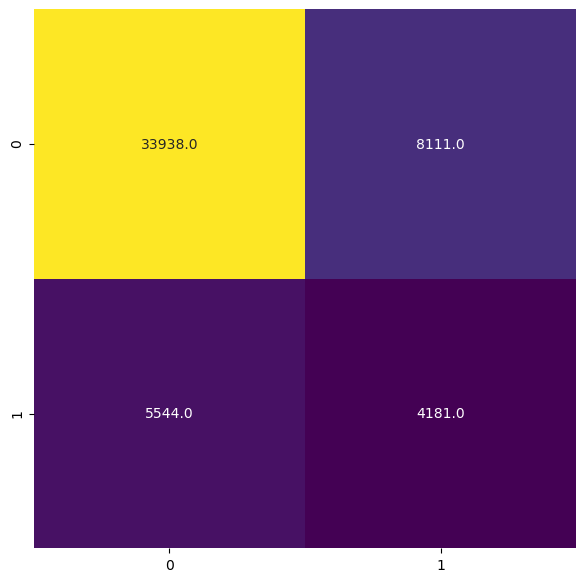

In [75]:
import seaborn as sns
import matplotlib.pyplot as plt

labels = ["0", "1"]
_ = plt.figure(figsize=(7, 7))
sns.heatmap(metrics.confusionMatrix().toArray(),
            cmap='viridis',
            annot=True,fmt='0',
            cbar=False, 
            xticklabels=labels, 
            yticklabels=labels)

### Oversampling Random Forest

In [50]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import IndexToString, StringIndexer, VectorIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics

# Train a RandomForest model.
rf = RandomForestClassifier(labelCol="Working_Weekend", featuresCol="features", numTrees=10)


# Train model.  This also runs the indexers.
model = rf.fit(train_over)

# Make predictions.
predictions = model.transform(testData)

# Select example rows to display.
#predictions.select("predictedLabel", "Severity", "features").show(5)

evaluator = MulticlassClassificationEvaluator(
    labelCol="Working_Weekend", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Test Accuracy = %g" % (accuracy))


Test Accuracy = 0.64041


In [51]:
feat_imp=model.featureImportances
from pyspark.ml.linalg import SparseVector
non_zero_elements = [(index, value) for index, value in zip(feat_imp.indices, feat_imp.values) if value != 0]
sorted_non_zero_elements = sorted(non_zero_elements, key=lambda x: x[1], reverse=True)
print('Le features più importanti per la predizione sono :')
for el in sorted_non_zero_elements:
    if el[0]>=24:
        print(num_col[len(num_col)-1], 'con un\'importanza dello', el[1])
    else:
        print(num_col[el[0]], 'con un\'importanza dello', el[1])

Le features più importanti per la predizione sono :
Distance_mi con un'importanza dello 0.2577306376632109
Astronomical_Twilight con un'importanza dello 0.25113639105825236
hour con un'importanza dello 0.22036584494644237
Severity con un'importanza dello 0.1331408507375343
Humidity_perc con un'importanza dello 0.030487571178669015
Temperature_F con un'importanza dello 0.02599470938445227
month con un'importanza dello 0.01917355376517502
Start_Lat con un'importanza dello 0.015557106660562009
Start_Lng con un'importanza dello 0.014246228060488196
Visibility_mi con un'importanza dello 0.009051925883467692
Wind_Speed_mph con un'importanza dello 0.007212016664554176
Weather_Condition_1hot con un'importanza dello 0.005641615379543949
Weather_Condition_1hot con un'importanza dello 0.003940459520748699
Traffic_Signal con un'importanza dello 0.001311102997465388
Weather_Condition_1hot con un'importanza dello 0.0012567004008505495
Railway con un'importanza dello 0.001193735120904679
Precipitatio

In [77]:
from pyspark.mllib.evaluation import MulticlassMetrics
# Calcolare precision, recall e F1-score
predictionAndLabels = predictions.select("prediction", "Working_Weekend").rdd.map(lambda x: (float(x[0]), float(x[1])))
metrics = MulticlassMetrics(predictionAndLabels)

list_avg=[]
for i in range(2):
    precision = metrics.precision(label=float(i))  
    recall = metrics.recall(label=float(i))
    f1Score= metrics.fMeasure(label=float(i)) # need .0
    print("Precision for class ",i,": {:.2%}".format(precision))
    print("Recall for class ",i,": {:.2%}".format(recall))
    print("avg_F1-Score for class ",i,": {:.2%}".format(f1Score))
    list_avg.append(f1Score)
    print('----------------------------')
sum_=0
print(list_avg)
for elem in list_avg:
    sum_+=elem

avg_f1=sum_/2
print('----------------------')

print("avg_F1-Score: {:.2%}".format(avg_f1))

/opt/conda/lib/python3.10/site-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Precision for class  0 : 81.22%
Recall for class  0 : 100.00%
avg_F1-Score for class  0 : 89.64%
----------------------------
Precision for class  1 : 100.00%
Recall for class  1 : 0.02%
avg_F1-Score for class  1 : 0.04%
----------------------------
[0.8963664851152727, 0.0004112264829855043]
----------------------
avg_F1-Score: 44.84%


<Axes: >

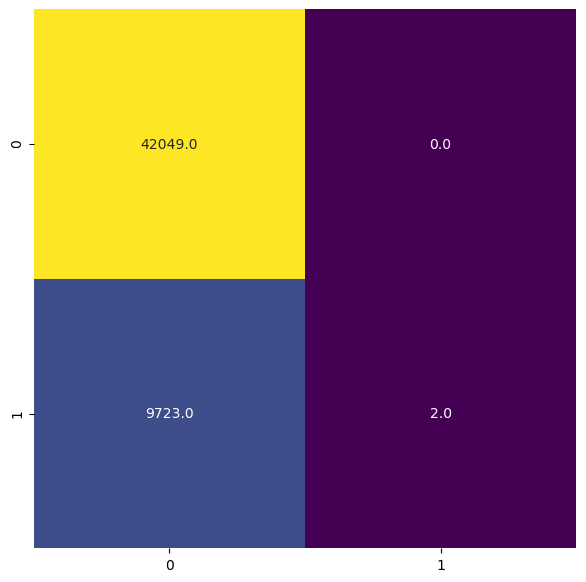

----------------------------------------
Exception occurred during processing of request from ('127.0.0.1', 47712)
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/socketserver.py", line 316, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/opt/conda/lib/python3.10/socketserver.py", line 347, in process_request
    self.finish_request(request, client_address)
  File "/opt/conda/lib/python3.10/socketserver.py", line 360, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/opt/conda/lib/python3.10/socketserver.py", line 747, in __init__
    self.handle()
  File "/opt/conda/lib/python3.10/site-packages/pyspark/accumulators.py", line 295, in handle
    poll(accum_updates)
  File "/opt/conda/lib/python3.10/site-packages/pyspark/accumulators.py", line 267, in poll
    if self.rfile in r and func():
  File "/opt/conda/lib/python3.10/site-packages/pyspark/accumulators.py", line 271, in accum_updates
   

In [78]:
import seaborn as sns
import matplotlib.pyplot as plt

labels = ["0", "1"]
_ = plt.figure(figsize=(7, 7))
sns.heatmap(metrics.confusionMatrix().toArray(),
            cmap='viridis',
            annot=True,fmt='0',
            cbar=False, 
            xticklabels=labels, 
            yticklabels=labels)

23/12/13 18:05:53 WARN DAGScheduler: Broadcasting large task binary with size 1193.2 KiB
23/12/13 18:06:06 WARN DAGScheduler: Broadcasting large task binary with size 1563.7 KiB
23/12/13 18:06:18 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
23/12/13 18:06:39 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
23/12/13 18:06:54 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB


Test Accuracy = 0.667265
Alberi :  5 maxDepth :  10


/opt/conda/lib/python3.10/site-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Precision for class  0 : 89.90%
Recall for class  0 : 66.50%
avg_F1-Score for class  0 : 76.45%
----------------------------
Precision for class  1 : 31.85%
Recall for class  1 : 67.69%
avg_F1-Score for class  1 : 43.32%
----------------------------
[0.764513703779646, 0.4331918533872931]
----------------------
avg_F1-Score: 59.89%


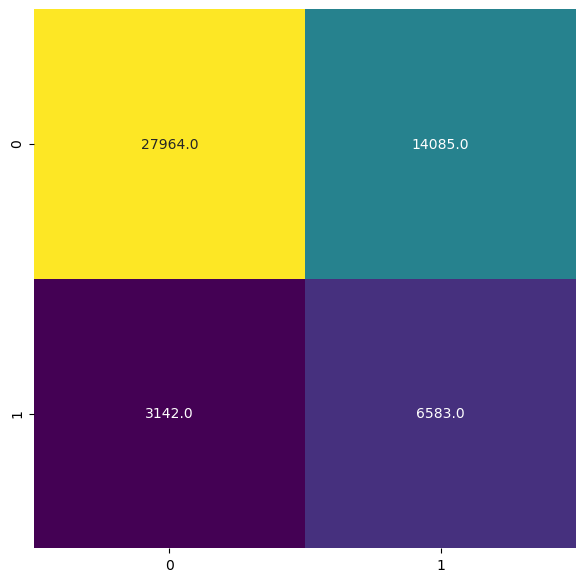

23/12/13 18:09:22 WARN DAGScheduler: Broadcasting large task binary with size 1193.2 KiB
23/12/13 18:09:28 WARN DAGScheduler: Broadcasting large task binary with size 1563.7 KiB
23/12/13 18:09:35 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
23/12/13 18:09:47 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
23/12/13 18:09:58 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
23/12/13 18:10:18 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB


Test Accuracy = 0.729787
Alberi :  5 maxDepth :  15


/opt/conda/lib/python3.10/site-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(
23/12/13 18:10:24 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
23/12/13 18:10:24 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB


Precision for class  0 : 91.45%
Recall for class  0 : 73.61%
avg_F1-Score for class  0 : 81.57%
----------------------------
Precision for class  1 : 38.10%
Recall for class  1 : 70.23%
avg_F1-Score for class  1 : 49.40%
----------------------------
[0.8156736672903107, 0.4940325497287523]
----------------------
avg_F1-Score: 65.49%


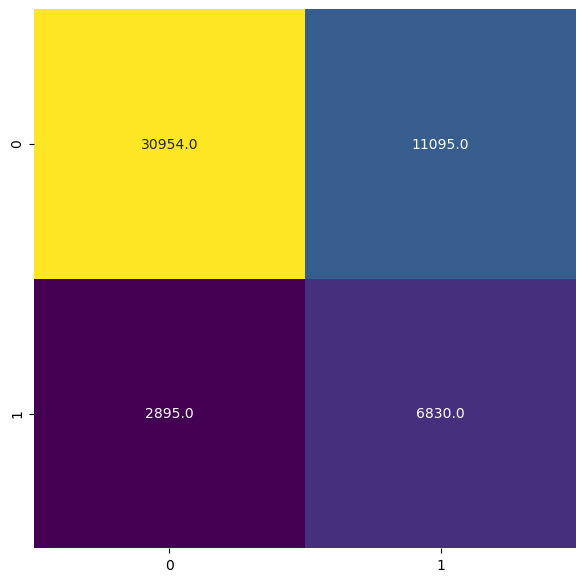

23/12/13 18:12:26 WARN DAGScheduler: Broadcasting large task binary with size 1193.2 KiB
23/12/13 18:12:32 WARN DAGScheduler: Broadcasting large task binary with size 1563.7 KiB
23/12/13 18:12:39 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
23/12/13 18:12:47 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
23/12/13 18:12:59 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
23/12/13 18:13:15 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB
23/12/13 18:13:37 WARN DAGScheduler: Broadcasting large task binary with size 5.4 MiB
23/12/13 18:14:01 WARN DAGScheduler: Broadcasting large task binary with size 6.6 MiB
23/12/13 18:14:45 WARN DAGScheduler: Broadcasting large task binary with size 8.0 MiB
23/12/13 18:16:01 WARN DAGScheduler: Broadcasting large task binary with size 9.3 MiB
23/12/13 18:17:23 WARN DAGScheduler: Broadcasting large task binary with size 5.6 MiB


Test Accuracy = 0.799281
Alberi :  5 maxDepth :  20


/opt/conda/lib/python3.10/site-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(
23/12/13 18:17:32 WARN DAGScheduler: Broadcasting large task binary with size 5.6 MiB
23/12/13 18:17:33 WARN DAGScheduler: Broadcasting large task binary with size 5.6 MiB


Precision for class  0 : 91.98%
Recall for class  0 : 82.48%
avg_F1-Score for class  0 : 86.97%
----------------------------
Precision for class  1 : 47.63%
Recall for class  1 : 68.90%
avg_F1-Score for class  1 : 56.33%
----------------------------
[0.869699325425684, 0.563251239808355]
----------------------
avg_F1-Score: 71.65%


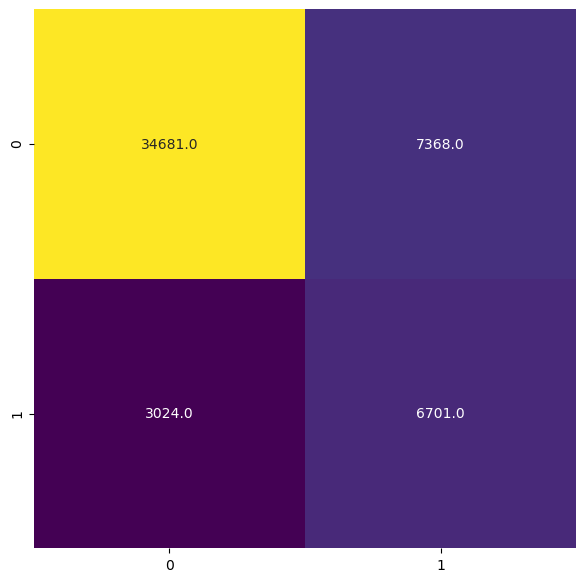

In [31]:
for maxDepth in range(10,21,5):
    rf = RandomForestClassifier(labelCol="Working_Weekend", featuresCol="features", numTrees=5,maxDepth= maxDepth) 
    # Addestra il modello sul set di dati sottocampionato
    model = rf.fit(train_over) 
    predictions = model.transform(testData)
    evaluator = MulticlassClassificationEvaluator(
    labelCol="Working_Weekend", predictionCol="prediction", metricName="accuracy")
    accuracy = evaluator.evaluate(predictions)
    print("Test Accuracy = %g" % accuracy) 
    print("Alberi : ",5,"maxDepth : ",maxDepth)
    from pyspark.mllib.evaluation import MulticlassMetrics
    # Calcolare precision, recall e F1-score
    predictionAndLabels = predictions.select("prediction", "Working_Weekend").rdd.map(lambda x: (float(x[0]), float(x[1])))
    metrics = MulticlassMetrics(predictionAndLabels)

    list_avg=[]
    for i in range(2):
        precision = metrics.precision(label=float(i))  
        recall = metrics.recall(label=float(i))
        f1Score= metrics.fMeasure(label=float(i)) # need .0
        print("Precision for class ",i,": {:.2%}".format(precision))
        print("Recall for class ",i,": {:.2%}".format(recall))
        print("avg_F1-Score for class ",i,": {:.2%}".format(f1Score))
        list_avg.append(f1Score)
        print('----------------------------')
    sum_=0
    print(list_avg)
    for elem in list_avg:
        sum_+=elem

    avg_f1=sum_/2
    print('----------------------')

    print("avg_F1-Score: {:.2%}".format(avg_f1))
    import seaborn as sns
    import matplotlib.pyplot as plt
    labels = ["0", "1"]
    _ = plt.figure(figsize=(7, 7))
    sns.heatmap(metrics.confusionMatrix().toArray(),
                cmap='viridis',
                annot=True,fmt='0',
                cbar=False, 
                xticklabels=labels, 
                yticklabels=labels)
    plt.show()